In [1]:
# Get all imports
from sklearn.datasets import make_moons, make_swiss_roll
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm
from collections import Counter
import random
import torch
# Create a device variable which will be used to shift model and data to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def is_inside_square(x, y, x_min, x_max, y_min, y_max, center):
    """return True if point (x,y) lies inside square with side s"""
    return (x-center[0] > x_min and x-center[0] < x_max) and (y-center[1] > y_min and y-center[1] < y_max)


def generate_datagrid(x_min, x_max, y_min, y_max, interval, center, square_x_min, square_x_max, square_y_min, square_y_max):
    """generate grid based with samples belonging to a square class"""
    # generate datapoints over the entire grid
    X1 = np.arange(x_min, x_max, interval)
    X2 = np.arange(y_min, y_max, interval)
    XX1, XX2 = np.meshgrid(X1, X2)

    # reshaping required to generate datapoints in 2 dimensions
    X1 = XX1.reshape((np.prod(XX1.shape), 1))
    X2 = XX2.reshape((np.prod(XX2.shape), 1))
    X = np.concatenate((X1, X2), axis=1)
    Y = list()
    
    # boundary check
    for i in range(len(X)):
        if is_inside_square(X[i, 0], X[i, 1], square_x_min, square_x_max, square_y_min, square_y_max, center):
            Y.append(1)
        else:
            Y.append(0)
    return X, Y

In [3]:
def plot_data(X, Y, title, filename, dpi, plot_s):
    """plot datagrid"""
    sns.scatterplot(x=X[:, 0], y=X[:, 1], c=["#FDAC29" if i==1 else "#2B3751" for i in Y], s=plot_s)
    sns.despine()
    plt.show()

Data Shape (4489, 2) 4489
Target Variable Distribution Counter({0: 2280, 1: 2209}) 



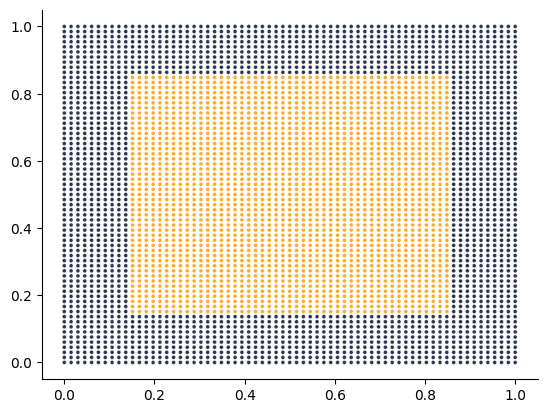

In [4]:
INTERVAL = 0.3
DATA_X_MIN, DATA_Y_MIN = 10, 10
DATA_X_MAX, DATA_Y_MAX = 30, 30
CENTER = [20, 20]
SQUARE_X_MIN, SQUARE_X_MAX = -7, 7
SQUARE_Y_MIN, SQUARE_Y_MAX = -7, 7
DPI = 400
PLOT_S = 8

# get data
X, Y = generate_datagrid(DATA_X_MIN, DATA_X_MAX, DATA_Y_MIN, DATA_Y_MAX, INTERVAL, CENTER, SQUARE_X_MIN, SQUARE_X_MAX, SQUARE_Y_MIN, SQUARE_Y_MAX)

print("Data Shape", X.shape, len(Y))
print("Target Variable Distribution", Counter(Y), "\n")
Y = np.asarray(Y)

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# plot grid
plot_data(X, Y, "Square Dataset", "actual_data_square", DPI, PLOT_S)

In [5]:
class FFN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Linear(2, 3)
        self.layer2 = torch.nn.Linear(3, 1)
    
    def forward(self, x):
        # Change the activation function and see what effect we get
        x = torch.nn.ReLU()(self.layer1(x))
        x = torch.nn.Sigmoid()(self.layer2(x))
        return x[:,0]

In [6]:
# First create a pytorch dataset from the numpy data
dataset_train = torch.utils.data.TensorDataset(torch.from_numpy(X), torch.from_numpy(Y))
# Create a dataloader object which will create batches of data
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle=False)

In [7]:
# Set the number of epochs to be used
epochs = 50
# Create the model
model = FFN().to(device)
# Define Loss
loss_function = torch.nn.BCELoss()
# Define Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# These two lists will be used to store average loss and accuracy for each epoch
total_loss, acc = list(), list()
# Now write out the training procedure
for epoch in range(epochs):
    print("\n\nEpoch:", epoch+1)
    # Each batch produces a loss, predictions and target
    batch_loss, batch_preds, batch_target = 0, list(), list()
    # For each batch, train the model
    for x, y in tqdm(dataloader_train, total=len(dataloader_train)):
        # Make sure that data is on the same device as the model
        x, y = x.to(device), y.to(device)
        # Remove all previous gradients
        optimizer.zero_grad()
        # Get predictions by performing a forward pass
        preds = model.forward(x.float())
        # Calculate error
        loss = loss_function(preds, y.float())
        # Calculate all the gradients for each layer
        loss.backward()
        # Finall, update the weights
        optimizer.step()
        # Save the loss
        batch_loss+= loss.item()
        # Save the predictions and target
        batch_preds.extend([1 if i >= 0.5 else 0 for i in preds.cpu().detach().numpy()])
        batch_target.extend(y.cpu().detach().numpy())
    # Calculate average loss
    total_loss.append(batch_loss/len(dataloader_train))
    # Calculate accuracy for this epoch
    acc.append(accuracy_score(batch_target, batch_preds))
    print("Loss:", total_loss[-1], "\tAcc:", acc[-1])



Epoch: 1


  0%|          | 0/141 [00:00<?, ?it/s]

Loss: 0.5678754816664026 	Acc: 0.697482735575852


Epoch: 2


  0%|          | 0/141 [00:00<?, ?it/s]

Loss: 0.4919530565434314 	Acc: 0.7538427266651816


Epoch: 3


  0%|          | 0/141 [00:00<?, ?it/s]

Loss: 0.4855986107537087 	Acc: 0.7591891289819559


Epoch: 4


  0%|          | 0/141 [00:00<?, ?it/s]

Loss: 0.4785101849136623 	Acc: 0.7636444642459345


Epoch: 5


  0%|          | 0/141 [00:00<?, ?it/s]

Loss: 0.46708825632190026 	Acc: 0.771664067721096


Epoch: 6


  0%|          | 0/141 [00:00<?, ?it/s]

Loss: 0.4635678138716001 	Acc: 0.7741145021162843


Epoch: 7


  0%|          | 0/141 [00:00<?, ?it/s]

Loss: 0.4695219241135509 	Acc: 0.7707730006683002


Epoch: 8


  0%|          | 0/141 [00:00<?, ?it/s]

Loss: 0.45638418218768234 	Acc: 0.7765649365114725


Epoch: 9


  0%|          | 0/141 [00:00<?, ?it/s]

Loss: 0.4693502995139318 	Acc: 0.7678770327467141


Epoch: 10


  0%|          | 0/141 [00:00<?, ?it/s]

Loss: 0.4685041633903558 	Acc: 0.7701047003787035


Epoch: 11


  0%|          | 0/141 [00:00<?, ?it/s]

Loss: 0.4548468365736887 	Acc: 0.7779015370906661


Epoch: 12


  0%|          | 0/141 [00:00<?, ?it/s]

Loss: 0.4670930821844872 	Acc: 0.7703274671419025


Epoch: 13


  0%|          | 0/141 [00:00<?, ?it/s]

Loss: 0.46280615655242974 	Acc: 0.771664067721096


Epoch: 14


  0%|          | 0/141 [00:00<?, ?it/s]

Loss: 0.45809347156091784 	Acc: 0.7752283359322789


Epoch: 15


  0%|          | 0/141 [00:00<?, ?it/s]

Loss: 0.4548492839573123 	Acc: 0.7752283359322789


Epoch: 16


  0%|          | 0/141 [00:00<?, ?it/s]

Loss: 0.4519777872883682 	Acc: 0.7776787703274671


Epoch: 17


  0%|          | 0/141 [00:00<?, ?it/s]

Loss: 0.45702979010893097 	Acc: 0.7752283359322789


Epoch: 18


  0%|          | 0/141 [00:00<?, ?it/s]

Loss: 0.45344327654398925 	Acc: 0.774782802405881


Epoch: 19


  0%|          | 0/141 [00:00<?, ?it/s]

Loss: 0.45837334242272887 	Acc: 0.7754511026954778


Epoch: 20


  0%|          | 0/141 [00:00<?, ?it/s]

Loss: 0.47242214028716933 	Acc: 0.7598574292715526


Epoch: 21


  0%|          | 0/141 [00:00<?, ?it/s]

Loss: 0.45627517438103965 	Acc: 0.7745600356426822


Epoch: 22


  0%|          | 0/141 [00:00<?, ?it/s]

Loss: 0.4530276388775372 	Acc: 0.7790153709066607


Epoch: 23


  0%|          | 0/141 [00:00<?, ?it/s]

Loss: 0.4592289827394147 	Acc: 0.7725551347738917


Epoch: 24


  0%|          | 0/141 [00:00<?, ?it/s]

Loss: 0.44773724949951715 	Acc: 0.7816885720650479


Epoch: 25


  0%|          | 0/141 [00:00<?, ?it/s]

Loss: 0.4444190022793222 	Acc: 0.7823568723546447


Epoch: 26


  0%|          | 0/141 [00:00<?, ?it/s]

Loss: 0.45283710872027894 	Acc: 0.7758966362218757


Epoch: 27


  0%|          | 0/141 [00:00<?, ?it/s]

Loss: 0.45382377928030404 	Acc: 0.7779015370906661


Epoch: 28


  0%|          | 0/141 [00:00<?, ?it/s]

Loss: 0.45701857968002346 	Acc: 0.7725551347738917


Epoch: 29


  0%|          | 0/141 [00:00<?, ?it/s]

Loss: 0.4554919850953082 	Acc: 0.7770104700378704


Epoch: 30


  0%|          | 0/141 [00:00<?, ?it/s]

Loss: 0.4496361167295605 	Acc: 0.7794609044330586


Epoch: 31


  0%|          | 0/141 [00:00<?, ?it/s]

Loss: 0.4556824597695195 	Acc: 0.7738917353530853


Epoch: 32


  0%|          | 0/141 [00:00<?, ?it/s]

Loss: 0.45313909142575365 	Acc: 0.7763421697482735


Epoch: 33


  0%|          | 0/141 [00:00<?, ?it/s]

Loss: 0.45385481269224315 	Acc: 0.7772332368010693


Epoch: 34


  0%|          | 0/141 [00:00<?, ?it/s]

Loss: 0.44889718653462457 	Acc: 0.778347070617064


Epoch: 35


  0%|          | 0/141 [00:00<?, ?it/s]

Loss: 0.4532261533094636 	Acc: 0.7761194029850746


Epoch: 36


  0%|          | 0/141 [00:00<?, ?it/s]

Loss: 0.4667554085559033 	Acc: 0.7698819336155046


Epoch: 37


  0%|          | 0/141 [00:00<?, ?it/s]

Loss: 0.45066787207380254 	Acc: 0.7776787703274671


Epoch: 38


  0%|          | 0/141 [00:00<?, ?it/s]

Loss: 0.4559653969943946 	Acc: 0.774782802405881


Epoch: 39


  0%|          | 0/141 [00:00<?, ?it/s]

Loss: 0.4474475527486057 	Acc: 0.7801292047226553


Epoch: 40


  0%|          | 0/141 [00:00<?, ?it/s]

Loss: 0.4453873490610867 	Acc: 0.7828024058810426


Epoch: 41


  0%|          | 0/141 [00:00<?, ?it/s]

Loss: 0.4489703286201396 	Acc: 0.7801292047226553


Epoch: 42


  0%|          | 0/141 [00:00<?, ?it/s]

Loss: 0.4510794500721262 	Acc: 0.778347070617064


Epoch: 43


  0%|          | 0/141 [00:00<?, ?it/s]

Loss: 0.44753923430933173 	Acc: 0.7810202717754511


Epoch: 44


  0%|          | 0/141 [00:00<?, ?it/s]

Loss: 0.4499336548730837 	Acc: 0.781465805301849


Epoch: 45


  0%|          | 0/141 [00:00<?, ?it/s]

Loss: 0.45134081527696435 	Acc: 0.7752283359322789


Epoch: 46


  0%|          | 0/141 [00:00<?, ?it/s]

Loss: 0.4451899608821734 	Acc: 0.7832479394074404


Epoch: 47


  0%|          | 0/141 [00:00<?, ?it/s]

Loss: 0.4436313689600491 	Acc: 0.7812430385386501


Epoch: 48


  0%|          | 0/141 [00:00<?, ?it/s]

Loss: 0.44992197743544343 	Acc: 0.7787926041434617


Epoch: 49


  0%|          | 0/141 [00:00<?, ?it/s]

Loss: 0.44609459029867293 	Acc: 0.7810202717754511


Epoch: 50


  0%|          | 0/141 [00:00<?, ?it/s]

Loss: 0.445025291214598 	Acc: 0.7816885720650479


In [8]:
total_preds = list()
for x, y in tqdm(dataloader_test, total=len(dataloader_test)):
    # Make sure that data is on the same device as the model
    x, y = x.to(device), y.to(device)
    # Get predictions by performing a forward pass
    preds = model.forward(x.float())
    # Save the predictions and target
    total_preds.extend([1 if i >= 0.5 else 0 for i in preds.cpu().detach().numpy()])

  0%|          | 0/141 [00:00<?, ?it/s]

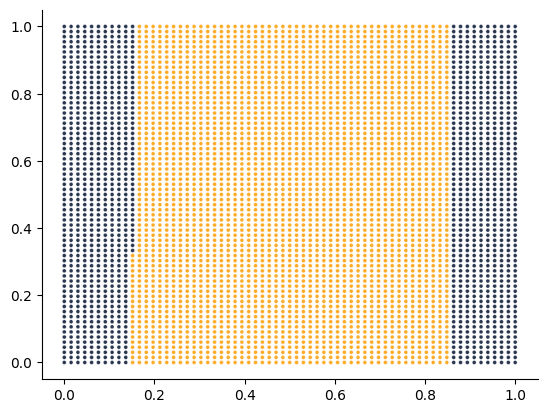

In [9]:
plot_data(X, total_preds, "Square Dataset", "actual_data_square", DPI, PLOT_S)